In [3]:
# test fft
from numpy.fft import fftshift, ifftshift, fftn, ifftn
import scipy.misc as misc
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


In [4]:
def build_mask(shape, subsampling_type='lf_focused', 
               subsampling_seed=42, subsampling_ratio=4, center_fraction=0.078125):
    """ Samples a mask that removes rows, one per instance in the batch
        1 indicates the pixel is known during training.
        Expected input shape is: nbatches x 1 x height x width x 2
        or single batch: 1 x height x width x 2.
        The 2 at the end is so this mask can be applied to complex style tensors directly,
        which is pytorch have the 2 complex dimensions at the end.

        Keep in mind that the fft operation in torch places the low frequencies
        at the corners of the tensor, and the high frequencies in the middle.
    """
    original_shape = shape
    if len(original_shape) == 4:
        shape = (1, *original_shape)

    np.random.seed(subsampling_seed)
    ratio = subsampling_ratio
    img_mask_np = np.zeros(shape).astype(np.float32) #img_fft_np.copy()
    nbatches = shape[0]
    nrows = shape[2]

    # Just simplfies the implementation
    if not float(ratio).is_integer():
        raise Exception("Subsampling ratio should be integral")
    
    radius = int(nrows*center_fraction/2)
    
    # For random methods
    # Sample a row for each batch
    actual_subsampling_nrow = int((1.0/subsampling_ratio - center_fraction) * nrows)
    row_pool = np.arange(radius, nrows-radius) # do not sample from the radius range
    row_sample = np.zeros((nbatches, nrows))
    row_ids = np.random.choice(row_pool, size=actual_subsampling_nrow, replace=False) 
    row_sample[:,row_ids] = 1
    
    inds = np.random.choice(nrows, size=int(1.0/subsampling_ratio*nrows), replace=False) 

    sampled_mask = np.expand_dims(row_sample, 1)[..., None, None] # Add extra dimensions
    sampled_mask = np.broadcast_to(sampled_mask, shape) # Expand

    # For center masking methods
    middle = int(nrows/2)
    non_center_inds = (
        list(range(radius, middle-radius)) +
        list(range(middle+radius, nrows-radius)))

    if subsampling_type == "random":
        img_mask_np[...,inds,:,:] = 1
    elif subsampling_type == "hf_focused":
        # region around center of image should be all 1
        img_mask_np[...,(middle-radius):(middle+radius),:,:] = 1
        # Random sample elsewhere
        img_mask_np[inds,:,:] = 1
    elif subsampling_type == "lf_focused":
        # Random sample everywhere
        img_mask_np[:] = sampled_mask
        # Add all low frequencies (Top and bottom)
        img_mask_np[...,:radius,:,:] = 1
        img_mask_np[...,(-radius):,:,:] = 1
    elif subsampling_type == "lf_focused_no_hf":
        # Random sample everywhere
        img_mask_np[:] = sampled_mask
        # region around either end should be all 1
        img_mask_np[...,:radius,:,:] = 1
        img_mask_np[...,(-radius):,:,:] = 1
        # region around center of image should be all 0
        img_mask_np[...,(middle-radius):(middle+radius),:,:] = 0
    elif subsampling_type == "alternating_plus_hf":
        img_mask_np[...,::ratio,:,:] = 1
        img_mask_np[...,(middle-radius):(middle+radius),:,:] = 1
        img_mask_np[...,:radius,:,:] = 0
        img_mask_np[...,(-radius):,:,:] = 0
    elif subsampling_type == "alternating_plus_lf":
        #https://arxiv.org/pdf/1709.02576.pdf
        img_mask_np[...,::ratio,:,:] = 1
        img_mask_np[...,(middle-radius):(middle+radius),:,:] = 0
        img_mask_np[...,:radius,:,:] = 1
        img_mask_np[...,(-radius):,:,:] = 1
    elif subsampling_type == "alternating":
        # Really doesn't work very well!
        img_mask_np[...,::ratio,:,:] = 1
    elif subsampling_type == "fromfile":
        mask2d = load_mask(subsample_mask_file)
        img_mask_np_raw = mask2d[None, None, :, :, None]
        img_mask_np =  np.tile(img_mask_np_raw, reps=(nbatches, 1, 1, 2))

    if len(original_shape) == 4:
        img_mask_np = img_mask_np[0, ...]

    return torch.from_numpy(img_mask_np)


def normal_pdf(length, sensitivity):
    return np.exp(-sensitivity * (np.arange(length) - length / 2)**2)
from numpy.lib.stride_tricks import as_strided

def cartesian_mask(shape, acc, sample_n=2, centred=False):
    """
    Code from: https://github.com/js3611/Deep-MRI-Reconstruction
    Sampling density estimated from implementation of kt FOCUSS
    shape: tuple - of form (..., nx, ny)
    acc: float - doesn't have to be integer 4, 8, etc..
    """
    N, Nx, Ny = int(np.prod(shape[:-2])), shape[-2], shape[-1]
    pdf_x = normal_pdf(Nx, 0.5/(Nx/10.)**2)
    lmda = Nx/(2.*acc)
    n_lines = int(Nx / acc)

    # add uniform distribution
    pdf_x += lmda * 1./Nx

    if sample_n:
        pdf_x[Nx//2-sample_n//2:Nx//2+sample_n//2] = 0
        pdf_x /= np.sum(pdf_x)
        n_lines -= sample_n

    mask = np.zeros((N, Nx))
    for i in range(N):
        idx = np.random.choice(Nx, n_lines, False, pdf_x)
        mask[i, idx] = 1

    if sample_n:
        mask[:, Nx//2-sample_n//2:Nx//2+sample_n//2] = 1

    size = mask.itemsize
    mask = as_strided(mask, (N, Nx, Ny), (size * Nx, size, 0))

    mask = mask.reshape(shape)

    if not centred:
        mask = np.fft.ifftshift(mask, axes=(-1, -2))

    return torch.from_numpy(mask)

def gen_kspace_mask(shape, ratio=0.25, mask_low_freqs = 5):
    
    h, w = shape
    mask_fft = (np.random.RandomState(42).rand(h) < ratio).astype(np.float32)
    mask_fft[:mask_low_freqs] = mask_fft[-mask_low_freqs:] = 1
    mask_fft = torch.from_numpy(mask_fft).view(1, h, 1, 1).expand(1,h,w,2)

    return mask_fft


In [106]:
im_tensor.shape
test_tensor = im_tensor.unsqueeze(0).unsqueeze(3)
test_tensor = torch.cat([test_tensor, torch.zeros(test_tensor.shape)], dim=3)
test_tensor.shape

torch.Size([1, 128, 128, 2])

torch.Size([1, 128, 128, 2])
torch.Size([1, 128, 128])
tensor(1.00000e-08 *
       -1.9452)


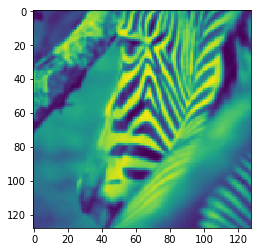

In [120]:
# d = torch.rfft(im_tensor.unsqueeze(0), 2, onesided=False, normalized=True)
d = torch.fft(test_tensor, 2, normalized=True)
print(d.shape)
m = torch.irfft(d, 2, onesided=False, normalized=True)
print(m.shape)
plt.imshow(m[0,:,:])
print((m[0,:,:] - im_tensor).mean())
# plt.figure()

# print(m[0,:,:,1].max())
# print(m[0,:,:,1].min())
# tmp = (m[0,:,:,0]**2. + m[0,:,:,1]**2.)**.5
# plt.imshow(m[0,:,:,1])
# print(m[0,:,:,0].shape)
# print(im_tensor.shape)
# print((m[0,:,:,0] - im_tensor).max())
# print((m[0,:,:,0] - im_tensor).min())
# print((tmp - im_tensor).max())
# print((tmp - im_tensor).min())
# plt.figure()
# plt.imshow(m[0,:,:,0] - im_tensor)

144 144
torch.FloatTensor
torch.Size([1, 128, 128, 2])
masked_img range -0.06548449397087097-1.0296201705932617
error tensor(1.00000e-07 *
       2.3842)


/Users/zizhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if __name__ == '__main__':


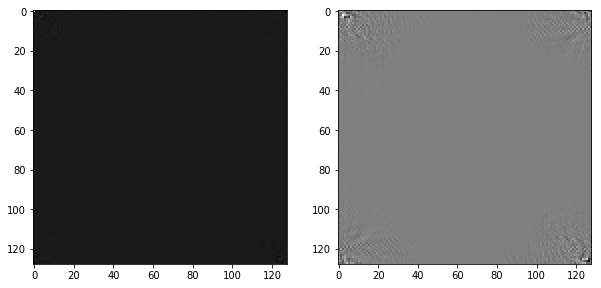

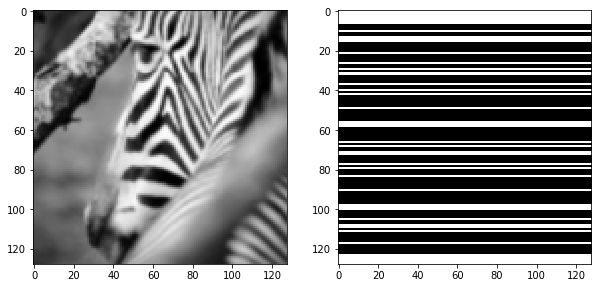

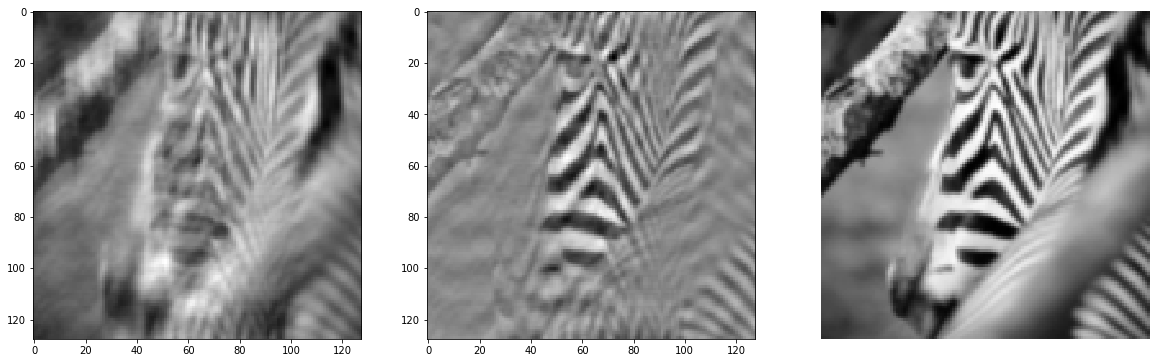

In [100]:
import torch
from scipy.ndimage import gaussian_filter
from PIL import Image
im = Image.open('pics/zebra.jpg').convert('L')
gim = np.asarray(im)
h,w = gim.shape
h, w = 144, 144
print(h, w)
gim = misc.imresize(gim,(h,w)) / 255
gim = gim[8:-8,8:-8]
h, w = 128, 128
im_tensor = torch.from_numpy(gim).float()
# im_tensor.mul_(2).add_(-1)
# im_tensor.clamp_(-1,1)

# mask_fft = build_mask((1,h,w,2))# print('mask size', mask.shape)
mask_fft = gen_kspace_mask([h,w], 0.25, 5)
# mask_fft = cartesian_mask((1,128,128), 4, centred=False).view(1,128,128,1).expand(1,128,128,2)

mask = mask_fft.float().numpy()
d = torch.rfft(im_tensor.view(1,h,w), 2, onesided=False, normalized=True)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(d[0][:,:,0], cmap='gray')
plt.subplot(122)
plt.imshow(d[0][:,:,1], cmap='gray')

plt.figure(figsize=(10,30))
plt.subplot(1,2,1)
plt.imshow(im_tensor, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(mask[0,:,:,0], cmap='gray')

mask_tensor = torch.from_numpy(mask)
print(d.type())
masked_mask_tensor = d * (mask_tensor)
# inverse mask and ifft
inv_masked_mask_tensor = d * (1-mask_tensor)
print(masked_mask_tensor.shape)
# masked_img = torch.irfft(masked_mask_tensor, 2, onesided=False)

masked_imgf = torch.ifft(masked_mask_tensor, 2, normalized=True)
masked_img = masked_imgf[:,:,:,0] #np.absolute(masked_imgf[:,:,:,0].numpy() + 1j* masked_imgf[:,:,:,1].numpy())

print('masked_img range {}-{}'.format(masked_img.min(), masked_img.max()))
# print(masked_img.shape)
# masked_img = torch.fFloatTensor(gaussian_filter(masked_img.data, sigma=0.4)) # apply
inv_masked_imgf = torch.ifft(inv_masked_mask_tensor, 2, normalized=True)
# inv_masked_img = inv_masked_imgf[:,:,:,0] + inv_masked_imgf[:,:,:,1]
inv_masked_img = inv_masked_imgf[:,:,:,0] #np.absolute(inv_masked_imgf[:,:,:,0].numpy() + 1j* inv_masked_imgf[:,:,:,1].numpy())

plt.figure(figsize=(20,50))
plt.subplot(131)
plt.imshow(masked_img[0], cmap='gray')
plt.subplot(132)
plt.imshow(inv_masked_img[0], cmap='gray')
plt.subplot(133)
plt.imshow((masked_img+inv_masked_img)[0], cmap='gray')

plt.axis('off')

print('error', ((masked_img+inv_masked_img)[0] - im_tensor).max())
# merge = masked_imgf[0]  + inv_masked_imgf[0]
# plt.figure(figsize=(10,10))

# _fft_masked_img = torch.fft(masked_imgf,2)
# plt.imshow(_fft_masked_img[0,:,:,0], cmap='gray')

In [28]:
import numpy as np
np.array(0)

array(0)

In [71]:
kspace.shape

NameError: name 'kspace' is not defined

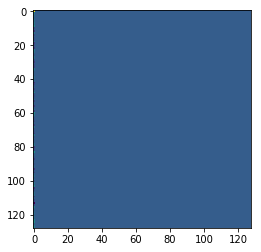

In [36]:
inv_mask = torch.ifft(torch.from_numpy(mask), 2)
plt.imshow(inv_mask[0,:,:,0])

# fft_mask_ = torch.rfft(inv_mask[0,:,:,0], 2, onesided=False)
# fft_mask = torch.fft(inv_mask, 2)
# plt.subplot(121)
# plt.imshow(fft_mask[0,:,:,0])
# plt.subplot(122)
# plt.imshow(fft_mask_[:,:,0] - fft_mask[0,:,:,0])
# (fft_mask_[:,:,0] - fft_mask[0,:,:,0]).min()

In [12]:
torch.ones(10)

tensor([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [20]:
# # load image net
# from data_util.ft_data_loader import get_train_valid_loader, get_test_loader
# import matplotlib.pyplot as plt
# import numpy as np
# %matplotlib inline
# loader = get_test_loader('/Users/zizhao/work/data', 10, 128, num_workers=0, 
#                             keep_ratio=0.1, which_dataset='ImageNet', normalize=False)
# loader = iter(loader)
# data, label, kspace = loader.next()
# plt.figure()
# for i in range(len(data)):
#     plt.figure()

#     plt.subplot(121)
#     plt.imshow(data[i][0].numpy(), cmap='gray')
#     plt.subplot(122)
#     plt.imshow(kspace[i][1].numpy(), cmap='gray')

In [ ]:
from data.ft_data_loader.ft_data_loader import get_train_valid_loader, get_test_loader

loader = get_test_loader(100, 40, 32, keep_ratio=0.25, num_workers=0, 
                            which_dataset='MNIST', normalize=False, data_dir='/Users/zizhao/work/data')
loader = iter(loader)
data, label, kspace = loader.next()

for i in range(len(data)):
    plt.subplot(121)
    plt.imshow(data[i][0].numpy(), cmap='gray')
    plt.subplot(122)
    plt.imshow(kspace[i][0].numpy(), cmap='gray')

## Experiment a least-squares problem of kspace

In [ ]:
print('masked kspace', masked_mask_tensor.shape)
print('inversed masked kspace', inv_masked_mask_tensor.shape)
a = np.concatenate([masked_mask_tensor[0,:,:,0], masked_mask_tensor[0,:,:,1]], axis=1)
b = np.concatenate([inv_masked_mask_tensor[0,:,:,0], inv_masked_mask_tensor[0,:,:,1]], axis=1)
c = np.concatenate([d[0,:,:,0], d[0,:,:,1]], axis=1)
img_ten = im_tensor.view(1,h,w,1)
img_part = torch.zeros_like(img_ten)
img_f = torch.cat([img_ten, img_part],3)
dd = torch.fft(img_f,2)
full_imgf = torch.ifft(dd, 2)
full_img = full_imgf[:,:,:,0]

def _to_kspace(data):
    # data is in [h,2w]
    h,w = data.shape
    r = np.concatenate([data[:,:w//2][:,:,np.newaxis], data[:,w//2:][:,:,np.newaxis]],2)
    r = r[np.newaxis,:,:,:]
    return r

x = np.linalg.lstsq(a, b)
x, residuals, rank, s = x
res = np.matmul(a, x)

In [1]:
# full image
plt.imshow(full_img[0], cmap='gray')
# test b
b_kspace = _to_kspace(b)
_b_img = torch.ifft(torch.from_numpy(b_kspace), 2)
plt.figure()
plt.imshow(_b_img[0,:,:,0], cmap='gray')
# test ax ~= b
res_kspace = _to_kspace(res)
_res_img = torch.ifft(torch.from_numpy(res_kspace), 2)
plt.figure()
plt.imshow(_res_img[0,:,:,0], cmap='gray') 

NameError: name 'plt' is not defined

In [7]:
import torch
import torch.nn as nn
input = torch.ones(20, 5, 10, 10)
# With Learnable Parameters
m = nn.LayerNorm(input.size()[1:])
# Without Learnable Parameters
m = nn.LayerNorm(input.size()[1:], elementwise_affine=False)
# Normalize over last two dimensions
m = nn.LayerNorm([10, 10])
# Normalize over last dimension of size 10
m = nn.LayerNorm(10)

In [121]:
import torch.nn.functional as F

def discretized_logistic(mean, logscale, binsize = 1/256.0, sample=None):
    # from PixelCNN++
    scale = torch.exp(logscale)
    sample = (torch.floor(sample / binsize) * binsize - mean) / scale
    logp = torch.log(F.sigmoid(sample + binsize / scale) - F.sigmoid(sample) + 1e-7)
    return logp

e = torch.zeros(10,10,10).normal_()
b = torch.zeros(10,10,10)
logscale = torch.ones(1)
loss = discretized_logistic(e, logscale, sample=b)
print(loss.sum())

tensor(-7964.3779)


In [74]:
torch.FloatTensor(3).shape

torch.Size([3])

In [1]:
import numpy as np
mu, sigma = 0, 0.1 # mean and standard deviation
s = np.random.normal(mu, sigma, 10000)
first = ((s - mu)**2).mean()
second = ((s.mean() - mu)**2)
print(first)
print(second)

0.010216412961937064
7.511054273285605e-10


In [10]:
import torch
data = torch.nn.Parameter(torch.zeros(1,1))

In [14]:
from torch.autograd.variable import Variable
x = Variable(torch.Tensor([34, 54]), requires_grad=True)

In [18]:
y = x * 2

#with torch.no_grad():
z = x * 4
    
z.backward(torch.ones_like(z))

## Test SSIM

In [42]:
from PIL import Image
import numpy as np
from util import pytorch_mssim
import torch
gt = np.asarray(Image.open('/Users/zizhao/individualImage_gt.png')).astype(np.float32) / 255
res = np.asarray(Image.open('/Users/zizhao/individualImage_results.png')).astype(np.float32)/ 255

In [43]:
gt_tensor = torch.from_numpy(gt)[:,:,0].view(1,1,1042,1042).expand(1,1,1042,1042)
res_tensor = torch.from_numpy(res)[:,:,0].view(1,1,1042,1042).expand(1,1,1042,1042)
pytorch_mssim.ssim(res_tensor*4-2, gt_tensor*4-2).item()

0.6993141174316406

In [39]:
from skimage.measure import compare_ssim as ssim
ssim(res[:,:,0]*4-2, gt[:,:,0]*4-2, value_range=4)

0.7103313559376214

In [53]:
np.random.seed(10)

indices =[a for a in range(10)]
np.random.shuffle(indices)
indices

[8, 2, 5, 6, 3, 1, 0, 7, 4, 9]

In [54]:
gt_tensor.shape

torch.Size([1, 1, 1042, 1042])

In [68]:
from torch import nn
model = nn.Sequential(*[
                                nn.ConvTranspose2d(1, 3,
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=True)])

In [5]:
import numpy as np
arr = np.array([[1,2,3,4], [5,6,7,8], [9,10,11,12]])
arr = np.delete(arr, 2, 1)
print(arr)

[[ 1  2  4]
 [ 5  6  8]
 [ 9 10 12]]
